# 3. Exploration of aggregated bike and weather data

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

from Utils.bikes import *
from Utils.weather import *

In [2]:
#Starting session
config = pyspark.SparkConf().setAll([('spark.executor.memory', '4g')])
spark = SparkSession.builder.appName('BigData1').getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [4]:
weather_raw = spark.read.option("header", True).csv("hdfs://localhost:9000/Data/D.C/New/weather.csv", sep=',', comment = '#')
stations_raw = spark.read.option("header", True).csv("hdfs://localhost:9000/Data/D.C/New/stations.csv", sep=',', comment = '#')
bikes_raw = spark.read.option("header", True).csv("hdfs://localhost:9000/Data/D.C/New/bikedata/*-capitalbikeshare-tripdata/*-capitalbikeshare-tripdata.csv", sep=',', comment = '#')

In [5]:
weather = process_weather(weather_raw)

In [6]:
stations = process_stations(stations_raw, spark)

In [7]:
bikes = process_bikes(bikes_raw)

In [8]:
bikes.count()

3397847

In [9]:
import ts.flint as flint
flintContext = flint.FlintContext(spark)

In [10]:
bikes = bikes.withColumn('time', bikes['start_date'])
bikes = bikes.sort(pyspark.sql.functions.col("time").asc())
bikes_ts = flintContext.read.dataframe(bikes)

In [11]:
weather = weather.withColumn('time', weather['date_time'])
weather = weather.sort(pyspark.sql.functions.col("time").asc())
weather_ts = flintContext.read.dataframe(weather)

In [12]:
joined_ts_data = bikes_ts.leftJoin(weather_ts, tolerance='360000s')

In [13]:
joined_ts_data.write.parquet("hdfs://localhost:9000/Data/D.C/New/joined.parquet")

In [14]:
joined = spark.read.parquet("hdfs://localhost:9000/Data/D.C/New/joined.parquet")

In [15]:
joined.count()

3397847

In [16]:
from pyspark.sql.functions import dayofyear, month, sum, avg, count

show_by_day = joined.groupBy(dayofyear("time").alias("dayofyear")).agg(sum("duration").alias("total_duration"), avg(month('time')).alias('month'), count('time').alias('count'))

In [17]:
show_by_day.sort('dayofyear')

dayofyear,total_duration,month,count
1,6816250,1.0,4517
2,5994586,1.0,6547
3,7052319,1.0,7599
4,7019778,1.0,7362
5,5032023,1.0,5106
6,7349048,1.0,6050
7,4872389,1.0,6216
8,6972948,1.0,7655
9,4748021,1.0,6408
10,4028534,1.0,5562


In [25]:
joined = joined.withColumn('dayofyear', dayofyear("time")).sort("time")

In [19]:
show_by_day2 = joined.groupBy(dayofyear("time").alias("dayofyear")).count()

In [20]:
show_by_day2.sort('dayofyear')

dayofyear,count
1,4517
2,6547
3,7599
4,7362
5,5106
6,6050
7,6216
8,7655
9,6408
10,5562


In [26]:
pandas_data = joined.select('dayofyear').toPandas()

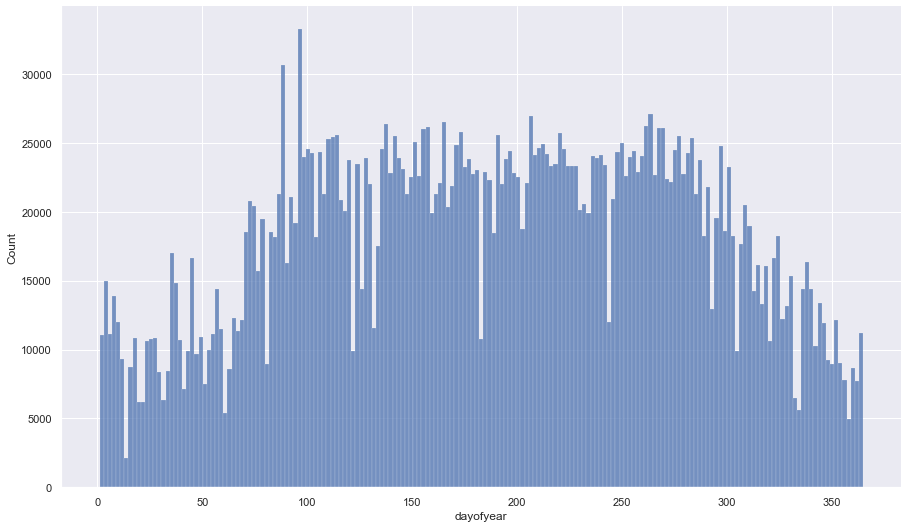

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.displot(pandas_data, x="dayofyear")
g.fig.set_figwidth(15)
g.fig.set_figheight(8)

In [41]:
#number of check-ins and check outs

stations_usage = joined.groupBy(F.col("start_station_id").alias("dayofyear")).count()

In [43]:
stations_usage = joined.select('start_station_id').sort('start_station_id').toPandas()

In [ ]:
g = sns.displot(pandas_data, x="start_station_id")
g.fig.set_figwidth(15)
g.fig.set_figheight(8)